# Machine Learning Solution

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import BooleanType, DateType, FloatType, IntegerType, LongType

In [2]:
# Spark Session
spark = SparkSession.builder.appName('Fraud-Detector').getOrCreate()

22/01/28 19:54:13 WARN Utils: Your hostname, francesc-Inspiron-5570 resolves to a loopback address: 127.0.1.1; using 192.168.1.141 instead (on interface wlp3s0)
22/01/28 19:54:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/28 19:54:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Read datasets
df_train = spark.read.csv('../data/clean_fraudTrain.csv', header=True)
df_test = spark.read.csv('../data/clean_fraudTest.csv', header=True)

In [4]:
# Show Pretty Data
df_train.limit(5).toPandas()

,credit_card_num,shop,category,amount,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,31
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,41
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.262,4154,Nature conservation officer,43.150704,-112.154481,0,57
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,M,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,52
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,33


In [5]:
# Cast Data
df_train.printSchema()

root
 |-- credit_card_num: string (nullable = true)
 |-- shop: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- age: string (nullable = true)



**We have to cast all the data because the csv, don't have meta-data that indicates the type.**

In [6]:
def cast_df(df):
    df = df.withColumn("credit_card_num", df.credit_card_num.cast(LongType()))
    df = df.withColumn("amount", df.amount.cast(FloatType()))
    df = df.withColumn("lat", df.lat.cast(FloatType()))
    df = df.withColumn("long", df.long.cast(FloatType()))
    df = df.withColumn("city_pop", df.city_pop.cast(IntegerType()))
    df = df.withColumn("merch_lat", df.merch_lat.cast(FloatType()))
    df = df.withColumn("merch_long", df.merch_long.cast(FloatType()))
    df = df.withColumn("is_fraud", df.is_fraud.cast(IntegerType()))
    df = df.withColumn("age", df.age.cast(IntegerType()))
    return df

In [7]:
# Cast
df_train = cast_df(df_train)
df_test = cast_df(df_test)

In [8]:
# Encode Categorical Variables
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline

cat_col = ['shop', 'category', 'gender', 'job']

list_string_indexer = [StringIndexer(inputCol=c, outputCol=c + "_indexed") for c in cat_col]
ppl = Pipeline(stages=list_string_indexer)

df_train_indexed = ppl.fit(df_train).transform(df_train).drop(*cat_col)
df_test_indexed = ppl.fit(df_test).transform(df_test).drop(*cat_col)

**We have to encode string variables to int, because the algorithm/s that we will use don't support strings.** 

In [9]:
df_train_indexed.limit(5).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed
0,2703186189652095,4.970000,36.078800,-81.178101,3495,36.011292,-82.048317,0,31,571.0,11.0,0.0,141.0
1,630423337322,107.230003,48.887798,-118.210503,149,49.159046,-118.186462,0,41,81.0,1.0,0.0,61.0
2,38859492057661,220.110001,42.180801,-112.262001,4154,43.150703,-112.154480,0,57,319.0,6.0,1.0,457.0
3,3534093764340240,45.000000,46.230598,-112.113800,1939,47.034332,-112.561073,0,52,40.0,0.0,1.0,232.0
4,375534208663984,41.959999,38.420700,-79.462898,99,38.674999,-78.632462,0,33,519.0,10.0,1.0,297.0


In [10]:
# Assemble Columns
from pyspark.ml.feature import VectorAssembler

numericCols = ['credit_card_num', 'amount', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age',
               'gender_indexed', 'category_indexed', 'shop_indexed', 'job_indexed']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

df_train_indexed = assembler.transform(df_train_indexed)
df_test_indexed = assembler.transform(df_test_indexed)

In [11]:
df_test_indexed.limit(5).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed,features
0,2291163933867244,2.860000,33.965900,-80.935501,333497,33.986389,-81.200714,0,52,469.0,7.0,1.0,40.0,"[2291163933867244.0, 2.859999895095825, 33.965..."
1,3573030041201292,29.840000,40.320702,-110.435997,302,39.450497,-109.960434,0,30,386.0,7.0,0.0,33.0,"[3573030041201292.0, 29.84000015258789, 40.320..."
2,3598215285024754,41.279999,40.672901,-73.536499,34496,40.495811,-74.196114,0,50,440.0,9.0,0.0,28.0,"[3598215285024754.0, 41.279998779296875, 40.67..."
3,3591919803438423,60.049999,28.569700,-80.819099,54767,28.812399,-80.883064,0,33,500.0,10.0,1.0,328.0,"[3591919803438423.0, 60.04999923706055, 28.569..."
4,3526826139003047,3.190000,44.252899,-85.016998,1126,44.959148,-85.884735,0,65,641.0,13.0,1.0,258.0,"[3526826139003047.0, 3.190000057220459, 44.252..."


In [12]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="features", numTrees=5,maxBins=693)
model = rf.fit(df_train_indexed)

In [13]:
# Make Predictions
predictions = model.transform(df_test_indexed)

In [14]:
predictions.limit(10).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed,features,rawPrediction,probability,prediction
0,2291163933867244,2.860000,33.965900,-80.935501,333497,33.986389,-81.200714,0,52,469.0,7.0,1.0,40.0,"[2291163933867244.0, 2.859999895095825, 33.965...","[4.985906930100128, 0.01409306989987108]","[0.9971813860200258, 0.0028186139799742166]",0.0
1,3573030041201292,29.840000,40.320702,-110.435997,302,39.450497,-109.960434,0,30,386.0,7.0,0.0,33.0,"[3573030041201292.0, 29.84000015258789, 40.320...","[4.987816242268888, 0.012183757731111532]","[0.9975632484537776, 0.0024367515462223066]",0.0
2,3598215285024754,41.279999,40.672901,-73.536499,34496,40.495811,-74.196114,0,50,440.0,9.0,0.0,28.0,"[3598215285024754.0, 41.279998779296875, 40.67...","[4.987816242268888, 0.012183757731111532]","[0.9975632484537776, 0.0024367515462223066]",0.0
3,3591919803438423,60.049999,28.569700,-80.819099,54767,28.812399,-80.883064,0,33,500.0,10.0,1.0,328.0,"[3591919803438423.0, 60.04999923706055, 28.569...","[4.988889722309922, 0.011110277690078506]","[0.9977779444619843, 0.002222055538015701]",0.0
4,3526826139003047,3.190000,44.252899,-85.016998,1126,44.959148,-85.884735,0,65,641.0,13.0,1.0,258.0,"[3526826139003047.0, 3.190000057220459, 44.252...","[4.988889722309922, 0.011110277690078506]","[0.9977779444619843, 0.002222055538015701]",0.0
5,30407675418785,19.549999,42.193901,-76.736099,520,41.747158,-77.584198,0,29,214.0,4.0,0.0,275.0,"[30407675418785.0, 19.549999237060547, 42.1939...","[4.987816242268888, 0.012183757731111532]","[0.9975632484537776, 0.0024367515462223066]",0.0
6,213180742685905,133.929993,40.507000,-123.974297,1139,41.499458,-124.888725,0,69,494.0,9.0,0.0,68.0,"[213180742685905.0, 133.92999267578125, 40.506...","[4.987816242268888, 0.012183757731111532]","[0.9975632484537776, 0.0024367515462223066]",0.0
7,3589289942931264,10.370000,43.755699,-97.593597,343,44.495499,-97.728455,0,48,379.0,7.0,0.0,154.0,"[3589289942931264.0, 10.369999885559082, 43.75...","[4.984833450059096, 0.015166549940904106]","[0.9969666900118191, 0.003033309988180821]",0.0
8,3596357274378601,4.370000,41.000099,-78.235703,3688,41.546066,-78.120239,0,47,237.0,3.0,1.0,232.0,"[3596357274378601.0, 4.369999885559082, 41.000...","[4.988889722309922, 0.011110277690078506]","[0.9977779444619843, 0.002222055538015701]",0.0
9,3546897637165774,66.540001,31.659100,-96.809402,263,31.782919,-96.366188,0,64,422.0,8.0,0.0,23.0,"[3546897637165774.0, 66.54000091552734, 31.659...","[4.987816242268888, 0.012183757731111532]","[0.9975632484537776, 0.0024367515462223066]",0.0


# Metrics and evaluation

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9962948900433493
Test Error = 0.003705109956650743


In [16]:
# Metrics
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction', 'is_fraud']).withColumn('is_fraud', F.col('is_fraud').cast(
    FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction', 'is_fraud'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))


In [17]:
# Confusion Matrix
conf_matrix = metrics.confusionMatrix().toArray()

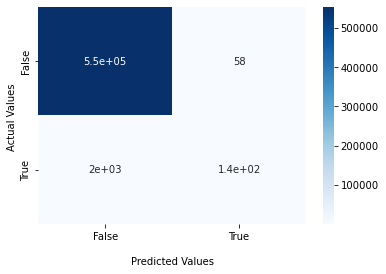

In [18]:
import seaborn as sns

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [19]:
# Decode Labels
list_index_string = [IndexToString(inputCol=c + "_indexed", outputCol=c) for c in cat_col]
ppl = Pipeline(stages=list_index_string)

df_train_decoded = ppl.fit(df_train_indexed).transform(df_train_indexed).drop(
    *['shop_indexed', 'gender_indexed', 'job_indexed', 'features'])
df_test_decoded = ppl.fit(predictions).transform(predictions).drop(
    *['shop_indexed', 'gender_indexed', 'job_indexed', 'features', 'rawPrediction', 'probability'])

In [20]:
df_test_decoded.filter(df_test_decoded.is_fraud != df_test_decoded.prediction).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,3560725013359375,24.840000,31.859900,-102.741302,23,32.575874,-102.604286,1,51,9.0,0.0,fraud_Hamill-D'Amore,health_fitness,F,Cytogeneticist
1,6564459919350820,780.520020,42.554501,-90.350800,1306,42.461128,-91.147148,1,62,11.0,0.0,"fraud_Rodriguez, Yost and Jenkins",misc_net,M,Public relations officer
2,6564459919350820,620.330017,42.554501,-90.350800,1306,42.771835,-90.158363,1,62,6.0,0.0,fraud_Nienow PLC,entertainment,M,Public relations officer
3,4005676619255478,1077.689941,30.459000,-90.902702,71335,31.204973,-90.261597,1,26,5.0,0.0,"fraud_Heathcote, Yost and Kertzmann",shopping_net,M,Herbalist
4,3560725013359375,842.650024,31.859900,-102.741302,23,31.315783,-102.736389,1,51,3.0,0.0,fraud_Hermann and Sons,shopping_pos,F,Cytogeneticist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2242176657877538,1039.420044,34.632301,-89.885498,14462,34.628433,-90.284782,1,62,5.0,0.0,"fraud_Mosciski, Ziemann and Farrell",shopping_net,M,Database administrator
2055,2242176657877538,289.269989,34.632301,-89.885498,14462,34.746063,-90.401093,1,62,1.0,0.0,fraud_Bauch-Raynor,grocery_pos,M,Database administrator
2056,2242176657877538,766.380005,34.632301,-89.885498,14462,33.771461,-90.651344,1,62,11.0,0.0,fraud_Jaskolski-Vandervort,misc_net,M,Database administrator
2057,6011975266774121,811.049988,39.030499,-76.551498,92106,39.427231,-77.086967,0,78,3.0,1.0,"fraud_Okuneva, Schneider and Rau",shopping_pos,F,"Accountant, chartered certified"


In [21]:
df_test_decoded.filter(df_test_decoded.is_fraud == 1).filter(df_test_decoded.prediction == 0).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,3560725013359375,24.840000,31.859900,-102.741302,23,32.575874,-102.604286,1,51,9.0,0.0,fraud_Hamill-D'Amore,health_fitness,F,Cytogeneticist
1,6564459919350820,780.520020,42.554501,-90.350800,1306,42.461128,-91.147148,1,62,11.0,0.0,"fraud_Rodriguez, Yost and Jenkins",misc_net,M,Public relations officer
2,6564459919350820,620.330017,42.554501,-90.350800,1306,42.771835,-90.158363,1,62,6.0,0.0,fraud_Nienow PLC,entertainment,M,Public relations officer
3,4005676619255478,1077.689941,30.459000,-90.902702,71335,31.204973,-90.261597,1,26,5.0,0.0,"fraud_Heathcote, Yost and Kertzmann",shopping_net,M,Herbalist
4,3560725013359375,842.650024,31.859900,-102.741302,23,31.315783,-102.736389,1,51,3.0,0.0,fraud_Hermann and Sons,shopping_pos,F,Cytogeneticist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2242176657877538,1041.510010,34.632301,-89.885498,14462,34.573471,-89.911011,1,62,3.0,0.0,"fraud_Willms, Kris and Bergnaum",shopping_pos,M,Database administrator
1997,2242176657877538,868.090027,34.632301,-89.885498,14462,34.091228,-90.390610,1,62,3.0,0.0,fraud_Kuhn LLC,shopping_pos,M,Database administrator
1998,2242176657877538,1039.420044,34.632301,-89.885498,14462,34.628433,-90.284782,1,62,5.0,0.0,"fraud_Mosciski, Ziemann and Farrell",shopping_net,M,Database administrator
1999,2242176657877538,289.269989,34.632301,-89.885498,14462,34.746063,-90.401093,1,62,1.0,0.0,fraud_Bauch-Raynor,grocery_pos,M,Database administrator


In [22]:
df_test_decoded.filter(df_test_decoded.is_fraud == 0).filter(df_test_decoded.prediction == 1).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,30376238035123,1084.130005,42.825001,-124.440903,217,42.852562,-124.431717,0,92,5.0,1.0,fraud_Fisher-Schowalter,shopping_net,F,Retail merchandiser
1,30181367542315,986.239990,44.241501,-121.011299,2016,44.338467,-121.222534,0,67,5.0,1.0,fraud_Bashirian Group,shopping_net,F,Local government officer
2,4003771737807706,718.489990,35.179100,-91.259399,37,35.231922,-91.660500,0,62,11.0,1.0,fraud_Klocko LLC,misc_net,F,"Lecturer, further education"
3,378858024506425,1002.200012,33.549400,-111.956497,17047,32.911949,-111.711876,0,85,5.0,1.0,fraud_Price Inc,shopping_net,F,Building surveyor
4,340103199302564,874.479980,36.118301,-79.568497,12486,35.952286,-80.080803,0,86,5.0,1.0,"fraud_Schmeler, Bashirian and Price",shopping_net,F,Arboriculturist
5,4783226709001,1153.329956,38.595699,-99.554001,320,39.043907,-99.463852,0,59,5.0,1.0,fraud_Rempel Inc,shopping_net,F,Film/video editor
6,584673555952,901.640015,47.519600,-101.233200,307,47.303455,-100.438591,0,90,3.0,1.0,fraud_Botsford Ltd,shopping_pos,F,Make
7,4247921790666,1210.770020,39.536999,-83.455002,22305,39.110046,-83.311516,0,81,5.0,1.0,fraud_Schmidt and Sons,shopping_net,F,Television floor manager
8,4155021259183870,1957.380005,34.703201,-98.959099,540,33.853733,-98.927521,0,37,5.0,1.0,fraud_Heathcote LLC,shopping_net,F,Research scientist (life sciences)
9,6011975266774121,1110.469971,39.030499,-76.551498,92106,39.978104,-75.963661,0,77,5.0,1.0,fraud_Boyer-Reichert,shopping_net,F,"Accountant, chartered certified"
